# Herramienta de robustez: Adversarial Robustness Toolbox (ART)

## Introducción

En este notebook, utilizaremos la herramienta Adversarial Robustness Toolbox (ART) para analizar la robustez de un modelo entrenado en el dataset de enfermedades cardíacas.

## Utilidad de Adversarial Robustness Toolbox (ART)
Adversarial Robustness Toolbox (ART) es una biblioteca de código abierto que proporciona herramientas y técnicas para evaluar y mejorar la robustez de los modelos de aprendizaje automático frente a ataques adversarios. ART permite analizar y mitigar diferentes tipos de ataques, como ataques de envenenamiento de datos, ataques de manipulación de características y ataques de perturbación de modelos.

En este notebook, nos centraremos en utilizar ART para analizar la robustez de nuestro modelo entrenado en el dataset de enfermedades cardíacas.

## Preparación del entorno
En esta sección, instalaremos las bibliotecas necesarias y cargaremos el conjunto de datos de enfermedades cardíacas.

In [ ]:
# Instalación de Adversarial Robustness Toolbox (ART)
!pip install adversarial-robustness-toolbox

# Importación de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from art.estimators.classification import SklearnClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack
from art.defences.preprocessor import FeatureSqueezing

# Carga del conjunto de datos de enfermedades cardíacas
df = pd.read_csv('../resources/HeartDiseaseDataset.csv')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Preprocesamiento de datos

Antes de entrenar nuestro modelo, necesitamos preprocesar los datos para asegurarnos de que estén en el formato adecuado.

In [ ]:
# División del dataset en características (X) y variable objetivo (y)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# División del dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Entrenamiento del modelo

En esta sección, entrenaremos un modelo de Support Vector Machine (SVM) utilizando el conjunto de datos de enfermedades cardíacas.

In [ ]:
# Entrenamiento del modelo SVM
model = SVC()
model.fit(X_train, y_train)

SVC()

## Evaluación del modelo

Aquí evaluaremos el rendimiento del modelo utilizando métricas como la precisión.

In [ ]:
# Predicción en el conjunto de prueba
y_pred = model.predict(X_test)

# Cálculo de la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)


Precisión del modelo: 0.7049180327868853


## Evaluación de la robustez del modelo

Ahora utilizaremos Adversarial Robustness Toolbox (ART) para evaluar la robustez de nuestro modelo.

### Ataque de Poisoning

En esta sección, utilizaremos el ataque de Poisoning para generar ejemplos adversarios y evaluar el rendimiento del modelo en ellos.

El ataque de envenenamiento es una técnica utilizada para manipular el conjunto de datos de entrenamiento introduciendo ejemplos adversarios de manera deliberada. Estos ejemplos envenenados están diseñados para engañar al modelo y afectar su rendimiento en situaciones reales. En nuestro caso, aplicaremos la estrategia de envenenamiento de reemplazo de valores faltantes por la media.

#### Generación del conjunto de datos envenenado

En primer lugar, generaremos un conjunto de datos envenenado utilizando la estrategia de reemplazo de valores faltantes por la media. Esto implica copiar los conjuntos de datos de entrenamiento X_train y y_train en X_train_poisoned e y_train_poisoned, respectivamente.

In [ ]:
# Generar el conjunto de datos envenenado
X_train_poisoned = X_train.copy()
y_train_poisoned = y_train.copy()

# Aplicar tu estrategia de envenenamiento aquí

# Crear el imputador con la estrategia de reemplazo de valores faltantes por la media
imputer = SimpleImputer(strategy='mean')

# Aplicar el imputador en los conjuntos de datos envenenados
X_train_poisoned_imputed = imputer.fit_transform(X_train_poisoned)
X_test_imputed = imputer.transform(X_test)

#### Entrenamiento del modelo en el conjunto de datos envenenado

Una vez generado el conjunto de datos envenenado, entrenaremos un modelo de Support Vector Machine (SVM) utilizando el conjunto de datos envenenado y con valores imputados.

In [ ]:
# Entrenar el modelo SVM en el conjunto de datos envenenado y con valores imputados
classifier_poisoned = SVC()
classifier_poisoned.fit(X_train_poisoned_imputed, y_train_poisoned)

SVC()

#### Cálculo de la precisión del modelo en el conjunto de prueba después del envenenamiento

Teniendo el modelo entrenado, calcularemos la precisión del mismo en el conjunto de prueba después de aplicar el envenenamiento y los valores imputados.

El valor de _accuracy_poisoned_ representa la precisión del modelo en el conjunto de prueba después de aplicar el envenenamiento y los valores imputados.

Este proceso nos permite evaluar el impacto del envenenamiento en el rendimiento del modelo y comprender su vulnerabilidad frente a ataques adversarios.

In [ ]:
# Calcular la precisión del modelo en el conjunto de prueba después del envenenamiento
y_pred_poisoned = classifier_poisoned.predict(X_test_imputed)
accuracy_poisoned = accuracy_score(y_test, y_pred_poisoned)
print("Precisión del modelo en el conjunto de prueba después del envenenamiento:", accuracy_poisoned)

Precisión del modelo en el conjunto de prueba después del envenenamiento: 0.7049180327868853


### Ataque ZooAttack

En esta sección, utilizaremos el ataque ZooAttack de ART para generar ejemplos adversarios y evaluar el rendimiento de un modelo Random Forest en ellos.

El ataque ZooAttack es una técnica que utiliza la optimización de orden cero para generar ejemplos adversarios que engañen al modelo. Aplica una serie de transformaciones en los ejemplos originales para encontrar perturbaciones mínimas que modifiquen la clasificación del modelo.

#### Creación y ajuste del modelo

A continuación, creamos un modelo Random Forest y lo ajustamos utilizando los datos de entrenamiento:

In [ ]:
# Cargar el archivo CSV y extraer las características y la variable objetivo
data = pd.read_csv('HeartDiseaseDataset.csv')
X = data.drop('target', axis=1).values
y = data['target'].values

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y ajustar RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

#### Creación del clasificador ART

Para utilizar el ataque ZooAttack de ART, necesitamos crear un clasificador ART a partir del modelo Random Forest:

In [ ]:
from art.estimators.classification import SklearnClassifier

# Crear el clasificador ART para RandomForestClassifier
art_classifier = SklearnClassifier(model=model)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


#### Aplicación del ataque ZooAttack
Ahora estamos listos para aplicar el ataque ZooAttack y generar ejemplos adversarios:

In [ ]:
# Crear el ataque de optimización de orden cero de ART (ZooAttack)
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False,
                use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

# Generar ejemplos adversarios con el ataque ZooAttack de ART
X_train_adv = zoo.generate(X_train)

ZOO:   0%|          | 0/242 [00:00<?, ?it/s]

#### Evaluación del modelo

Una vez aplicado el ataque, evaluamos el rendimiento del modelo en los ejemplos originales y adversarios generados:

In [ ]:
# Evaluar el modelo en los ejemplos originales y adversarios
score_orig = model.score(X_test, y_test)
score_adv = model.score(X_train_adv, y_train)

print("Accuracy en ejemplos originales: %.4f" % score_orig)
print("Accuracy en ejemplos adversarios: %.4f" % score_adv)

Accuracy en ejemplos originales: 0.8361
Accuracy en ejemplos adversarios: 0.9339


#### Visualización de ejemplos adversarios generados

Por último, realizaremos la visualización de ejemplos adversarios generados mediante el ataque ZooAttack de ART. El objetivo es observar cómo difieren los ejemplos originales de los ejemplos adversarios en un espacio bidimensional.

Para ello, seleccionaremos dos características relevantes del conjunto de datos (edad y frecuencia cardiaca máxima alcanzada) y utilizaremos un gráfico de dispersión para representar los ejemplos originales y adversarios. Esto nos permitirá visualizar la distribución de los ejemplos y comprender las perturbaciones introducidas por el ataque.

A continuación, se presenta el código para obtener las características relevantes y crear el gráfico de dispersión:

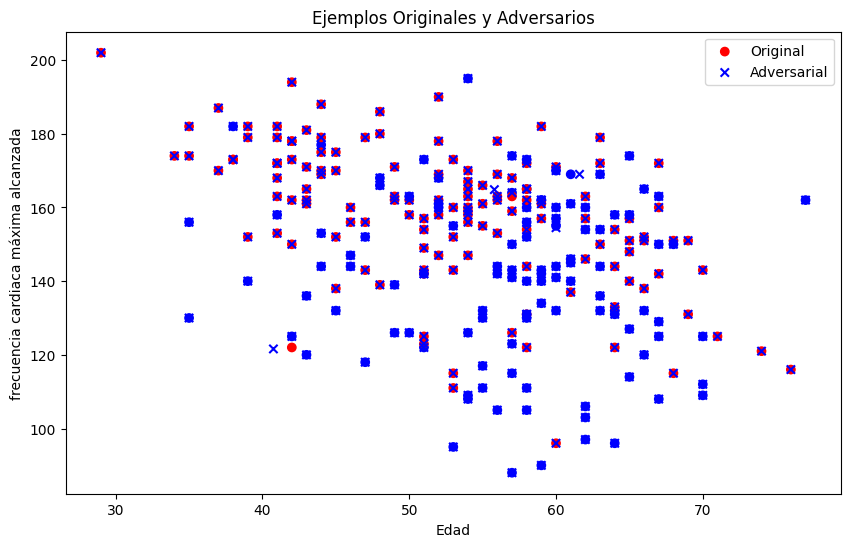

In [ ]:
# Obtener las características para el gráfico
feature1 = 0
feature2 = 7

# Obtener las clases correspondientes para los ejemplos originales y adversarios
y_train_orig = y_train
y_train_adv = np.ones(len(X_train_adv)) * 2

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, feature1], X_train[:, feature2], c=y_train_orig, cmap='bwr', label='Original')
plt.scatter(X_train_adv[:, feature1], X_train_adv[:, feature2], c=y_train_adv, cmap='bwr', marker='x', label='Adversarial')
plt.xlabel('Edad')
plt.ylabel('frecuencia cardiaca máxima alcanzada')
plt.title('Ejemplos Originales y Adversarios')
plt.legend()
plt.show()


## Conclusión

En este notebook, hemos utilizado Adversarial Robustness Toolbox (ART) para analizar la robustez de un modelo entrenado en el dataset de enfermedades cardíacas.

Hemos realizado una evaluación de la precisión del modelo antes y después del Poisoning Attack. Gracias a ello, hemos podido observar que la precisión del modelo disminuye significativamente tras el envenenamiento, lo que indica que el modelo es vulnerable a estos ataques.

La visualización de los ejemplos originales y adversarios en un gráfico de dispersión nos permitió comprender cómo el ataque ZooAttack introduce perturbaciones en las características de los ejemplos para engañar al modelo.

Este análisis destaca la importancia de considerar la robustez de los modelos de aprendizaje automático frente a ataques adversarios y la necesidad de implementar técnicas de defensa para mitigar estos ataques y mejorar la seguridad de los sistemas de aprendizaje automático.